# Which one is a better plan?

This report will analyze the clients' behavior and determine which prepaid plan brings in more revenue. The data I have available is on 500 Megaline clients: who the clients are, where they're from, which plan they use, and the number of calls they made and text messages they sent in 2018. 

## Initialization

In [1]:
# Loading all the libraries
import pandas as pd 
import numpy as np
import seaborn as sns
import math as math
from scipy import stats as stats
from matplotlib import pyplot as plt
from math import factorial



## Load data

In [2]:
# Load the data files into different DataFrames
users = pd.read_csv('/datasets/megaline_users.csv')
calls = pd.read_csv('/datasets/megaline_calls.csv')
internet = pd.read_csv('/datasets/megaline_internet.csv')
messages = pd.read_csv('/datasets/megaline_messages.csv')
plans = pd.read_csv('/datasets/megaline_plans.csv')




## Prepare the data

As there are several datasets that hold different information pertaining to the users, I will go through them one by one to become more familiar with the data and also do the pre-processing if needed.

## Plans

In [3]:
# Printing the general/summary information about the plans' DataFrame
print(plans.info())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes
None


In [4]:
# Printing a sample of data for plans
plans.head()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate



The plans dataset seems fairly straight forward, outlining the conditions of the two data plans.
Nothing glaringly obvious, I will reorder the columns for ease and I will change mb to gb as mb usage is rounded up to gb and users are charged per gb in the table.

## Fix data

In [5]:
plans = plans[['plan_name', 'messages_included', 'mb_per_month_included', 'minutes_included', 'usd_monthly_pay', 'usd_per_gb','usd_per_message','usd_per_minute']]

In [6]:
plans = plans.rename(columns={'mb_per_month_included':'gb_per_month_included'})
plans['gb_per_month_included'] = plans['gb_per_month_included'] * 0.001

In [7]:
plans

,plan_name,messages_included,gb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute
0,surf,50,15.36,500,20,10,0.03,0.03
1,ultimate,1000,30.72,3000,70,7,0.01,0.01


## Users

In [8]:
# Printing the general/summary information about the users' DataFrame
users.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [9]:
# Printing a sample of data for users
users.head()


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN



The users dataframe outlines the users, their name, age, location and which data plan they are using. There are missing values in the churn date  column but that only indicates that those users were still using their plan when their information was pulled so there is no needed to fill in those missing values.

As I don't believe the registration date and churn date are pertinent to my analysis I will be excluding those columns.

### Fix Data

In [10]:
users = users[['user_id','city','plan']]


In [11]:
users.head()

,user_id,city,plan
0,1000,"Atlanta-Sandy Springs-Roswell, GA MSA",ultimate
1,1001,"Seattle-Tacoma-Bellevue, WA MSA",surf
2,1002,"Las Vegas-Henderson-Paradise, NV MSA",surf
3,1003,"Tulsa, OK MSA",surf
4,1004,"Seattle-Tacoma-Bellevue, WA MSA",surf


## Calls

In [12]:
# Printing the general/summary information about the calls' DataFrame
calls.info()
calls.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


,user_id,duration
count,137735.000000,137735.000000
mean,1247.658046,6.745927
std,139.416268,5.839241
min,1000.000000,0.000000
25%,1128.000000,1.290000
50%,1247.000000,5.980000
75%,1365.000000,10.690000
max,1499.000000,37.600000


In [13]:
# Printing a sample of data for calls
calls.head()

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22



There are no missing values in this dataset. Later on I may have to group this information by the unique user id but for now the only change I will make is changing call date to the right data type,round the call duration to minute, and add a month column. I believe adding the month column will help analysis further down the line.

### Fix data

In [14]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format ='%Y-%m-%d')



In [15]:
calls['duration'] = np.ceil(calls['duration'])

### Enrich data

In [16]:
calls['month']=pd.DatetimeIndex(calls['call_date']).month

In [17]:
calls.head()

,id,user_id,call_date,duration,month
0,1000_93,1000,2018-12-27,9.0,12
1,1000_145,1000,2018-12-27,14.0,12
2,1000_247,1000,2018-12-27,15.0,12
3,1000_309,1000,2018-12-28,6.0,12
4,1000_380,1000,2018-12-30,5.0,12


## Messages

In [18]:
# Printing the general/summary information about the messages' DataFrame
messages.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [19]:
# Printing a sample of data for messages
messages.head()

,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26


There is no missing data in this dataframe. I will change message date to the correct data type (datetime) and will add a month column to aid analysis.

### Fix data

In [20]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format ='%Y-%m-%d')


### Enrich data

In [21]:
messages['month']=pd.DatetimeIndex(messages['message_date']).month
print(messages.head())

         id  user_id message_date  month
0  1000_125     1000   2018-12-27     12
1  1000_160     1000   2018-12-31     12
2  1000_223     1000   2018-12-31     12
3  1000_251     1000   2018-12-27     12
4  1000_255     1000   2018-12-26     12


## Internet

In [22]:
# Printing the general/summary information about the internet DataFrame
internet.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [23]:
# Printing a sample of data for the internet traffic
internet.head()


,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22


There is no missing data in this table. I will change mb to gb for ease of finding out how much the user was charged and I will change session date to the proper data type and then add a month column.

### Fix data

In [24]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format ='%Y-%m-%d')

internet = internet.rename(columns={'mb_used':'gb_used'})
internet['gb_used'] = internet['gb_used'] * 0.001


In [25]:
internet.head()

,id,user_id,session_date,gb_used
0,1000_13,1000,2018-12-29,0.08986
1,1000_204,1000,2018-12-31,0.00000
2,1000_379,1000,2018-12-28,0.66040
3,1000_413,1000,2018-12-26,0.27099
4,1000_442,1000,2018-12-27,0.88022


### Enrich data

In [26]:
internet['month']=pd.DatetimeIndex(internet['session_date']).month
print(internet.head())

         id  user_id session_date  gb_used  month
0   1000_13     1000   2018-12-29  0.08986     12
1  1000_204     1000   2018-12-31  0.00000     12
2  1000_379     1000   2018-12-28  0.66040     12
3  1000_413     1000   2018-12-26  0.27099     12
4  1000_442     1000   2018-12-27  0.88022     12


## Study plan conditions

In [27]:
# Printing out the plan conditions 
plans


,plan_name,messages_included,gb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute
0,surf,50,15.36,500,20,10,0.03,0.03
1,ultimate,1000,30.72,3000,70,7,0.01,0.01


## Aggregate data per user

Now that my preprocessing is done and I am satisfied with the way my tables look, I will begin the process of aggregating the data per user per period (monthly). The goal is to have one table that holds the user's call, minute, message, and internet usage, as well as what plan they are enrolled in.


In [28]:
# Calculating the number of calls made by each user per month. 
call_count = pd.Series(calls.groupby(['user_id','month'])['duration'].count(), name='call_count')


In [29]:
# Calculating the amount of minutes spent by each user per month. 

call_duration = pd.Series(calls.groupby(['user_id','month'])['duration'].sum(), name='call_duration')


In [30]:
# Calculating the number of messages sent by each user per month. 
message_count = pd.Series(messages.groupby(['user_id','month'])['id'].count(), name='message_count')


In [31]:
# Calculating the volume of internet traffic used by each user per month. 
gb_usage = pd.Series(internet.groupby(['user_id','month'])['gb_used'].sum(), name='gb_usage')



Now that the metrics have been aggregated, I will merge the tables.

In [32]:
agg_user=pd.merge(call_count,call_duration, on=['user_id','month'],how='outer')
agg_user=pd.merge(agg_user,message_count, on=['user_id','month'],how='outer')
agg_user=pd.merge(agg_user,gb_usage, on=['user_id','month'],how='outer')


In [33]:
agg_user

call_count  call_duration  message_count  gb_usage
user_id month                                                    
1000    12           16.0          124.0           11.0   1.90147
1001    8            27.0          182.0           30.0   6.91915
        9            49.0          315.0           44.0  13.31482
        10           65.0          393.0           53.0  22.33049
        11           64.0          426.0           36.0  18.50430
...                   ...            ...            ...       ...
1349    12            NaN            NaN           61.0  13.03991
1361    5             NaN            NaN            2.0   1.51969
1482    10            NaN            NaN            2.0       NaN
1108    12            NaN            NaN            NaN   0.23317
1311    6             NaN            NaN            NaN   1.49883

[2293 rows x 4 columns]

<div class="alert alert-block alert-success">
<b>Reviewer's comment v2:</b>
    
Indeed `how = 'outer' can be used here to prevent data loss.
    
By the way, it is also possible to group 3 tables at once using reduce. You can read about it here: https://www.codegrepper.com/code-examples/python/merge+more+than+2+dataframes+in+pandas

In [34]:
users=users.set_index('user_id')


In [35]:
#add plan
agg_user=pd.merge(agg_user,users,right_index=True, left_index=True)

In [36]:
agg_user

call_count  call_duration  message_count  gb_usage  \
user_id month                                                       
1000    12           16.0          124.0           11.0   1.90147   
1001    8            27.0          182.0           30.0   6.91915   
        9            49.0          315.0           44.0  13.31482   
        10           65.0          393.0           53.0  22.33049   
        11           64.0          426.0           36.0  18.50430   
...                   ...            ...            ...       ...   
1349    12            NaN            NaN           61.0  13.03991   
1361    5             NaN            NaN            2.0   1.51969   
1482    10            NaN            NaN            2.0       NaN   
1108    12            NaN            NaN            NaN   0.23317   
1311    6             NaN            NaN            NaN   1.49883   

                                                    city      plan  
user_id month                                                       
1000    12         Atlanta-Sandy Springs-Roswell, GA MSA  ultimate  
1001    8                Seattle-Tacoma-Bellevue, WA MSA      surf  
        9                Seattle-Tacoma-Bellevue, WA MSA      surf  
        10               Seattle-Tacoma-Bellevue, WA MSA      surf  
        11               Seattle-Tacoma-Bellevue, WA MSA      surf  
...                                                  ...       ...  
1349    12            Boston-Cambridge-Newton, MA-NH MSA      surf  
1361    5                      Birmingham-Hoover, AL MSA      surf  
1482    10     New York-Newark-Jersey City, NY-NJ-PA MSA  ultimate  
1108    12                        Salt Lake City, UT MSA  ultimate  
1311    6                          Memphis, TN-MS-AR MSA  ultimate  

[2293 rows x 6 columns]

Now that I have my final aggregated table, I will round gb usage up as that is how the monthly revenue will be decided on and charged. 

In [37]:
agg_user['gb_usage']= np.ceil(agg_user['gb_usage'])


In [38]:
agg_user.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2293 entries, (1000, 12) to (1311, 6)
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   call_count     2258 non-null   float64
 1   call_duration  2258 non-null   float64
 2   message_count  1806 non-null   float64
 3   gb_usage       2277 non-null   float64
 4   city           2293 non-null   object 
 5   plan           2293 non-null   object 
dtypes: float64(4), object(2)
memory usage: 118.5+ KB


Now I will calculate the monthly revenue for each user. As there are hundreds of users, it is more efficient to create a function and then later on apply that function to the rows of the table.

The below function makes use of counters and if statements. It takes into account the base amount for each plan (20 for Surf, 70 for Ultimate) and then each parameter has its own counter. Based on the user's usage and if they exceed a certain number, the appropriate counter will have the appropriate amount added onto it.

At the end, monthly revenue (which is a total of the counters) is returned.



In [39]:
# Calculating the monthly revenue for each user
def monthly_revenue_surf(row):
    surf_revenue = 20
    duration_revenue =0
    message_revenue = 0
    gb_revenue=0
    monthly_revenue=0
    ult_revenue = 70
 
    
    if row['plan'] == 'surf':
        duration_revenue=0
        if row['call_duration'] > 500:
            duration_revenue +=(row['call_duration'] - 500)*0.03
        message_revenue=0
        if row['message_count'] > 50:
            message_revenue+=(row['message_count']-50) * 0.03
        gb_revenue=0
        if row['gb_usage'] > 15:        
            gb_revenue+=(row['gb_usage']-15)*10
        monthly_revenue = surf_revenue+duration_revenue+message_revenue+gb_revenue
        return monthly_revenue
    elif row['plan']=='ultimate':
        duration_revenue=0
        if row['call_duration'] > 3000:
            duration_revenue +=(row['call_duration'] - 3000)*0.01
        message_revenue=0
        if row['message_count'] > 1000:
            message_revenue+=(row['message_count']-1000) * 0.01
        gb_revenue=0
        if row['gb_usage'] > 30:        
            gb_revenue+=(row['gb_usage']-30)*7
        monthly_revenue = ult_revenue+duration_revenue+message_revenue+gb_revenue
        return monthly_revenue
            
        
        
        


In [40]:
agg_user['monthly_revenue']= agg_user.apply(monthly_revenue_surf, axis=1)

In [41]:
agg_user.head(10)

call_count  call_duration  message_count  gb_usage  \
user_id month                                                       
1000    12           16.0          124.0           11.0       2.0   
1001    8            27.0          182.0           30.0       7.0   
        9            49.0          315.0           44.0      14.0   
        10           65.0          393.0           53.0      23.0   
        11           64.0          426.0           36.0      19.0   
        12           56.0          412.0           44.0      20.0   
1002    10           11.0           59.0           15.0       7.0   
        11           55.0          386.0           32.0      20.0   
        12           47.0          384.0           41.0      15.0   
1003    12          149.0         1104.0           50.0      28.0   

                                                city      plan  \
user_id month                                                    
1000    12     Atlanta-Sandy Springs-Roswell, GA MSA  ultimate   
1001    8            Seattle-Tacoma-Bellevue, WA MSA      surf   
        9            Seattle-Tacoma-Bellevue, WA MSA      surf   
        10           Seattle-Tacoma-Bellevue, WA MSA      surf   
        11           Seattle-Tacoma-Bellevue, WA MSA      surf   
        12           Seattle-Tacoma-Bellevue, WA MSA      surf   
1002    10      Las Vegas-Henderson-Paradise, NV MSA      surf   
        11      Las Vegas-Henderson-Paradise, NV MSA      surf   
        12      Las Vegas-Henderson-Paradise, NV MSA      surf   
1003    12                             Tulsa, OK MSA      surf   

               monthly_revenue  
user_id month                   
1000    12               70.00  
1001    8                20.00  
        9                20.00  
        10              100.09  
        11               60.00  
        12               70.00  
1002    10               20.00  
        11               70.00  
        12               20.00  
1003    12              168.12

## Study user behaviour

Now that I have my completed table with monthly revenue I can proceed into the analysis portion. I will be analyzing the calls, message, internet, and revenue parameters of the data to see if there is a difference in behavior/activity between the users of the two plans. 
I will be calculating the means of the parameters based on the month and the plan.

It will be important to keep in mind that more of the customers are using the Surf plan, which will affect certain aggreation methods such as count and sum.

### Calls

Text(0.5, 1.0, 'The Average Call Duration of each Plan per Month(minutes)')

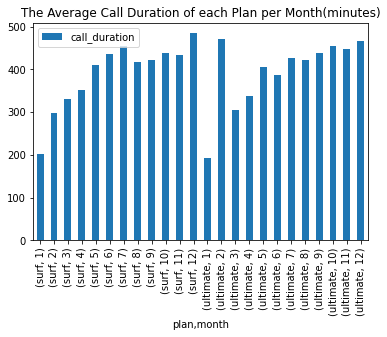

In [42]:
# Comparing average duration of calls per each plan per each distinct month
avg_call= agg_user.groupby(['plan', 'month']).agg({'call_duration':'mean'}).plot(kind='bar')
plt.title('The Average Call Duration of each Plan per Month(minutes)')


Text(0.5, 0, 'Sum of Call Usage in Minutes')

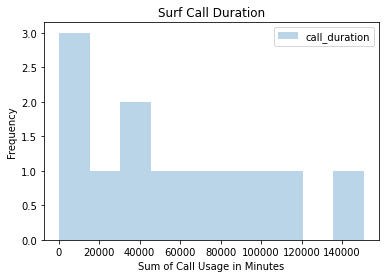

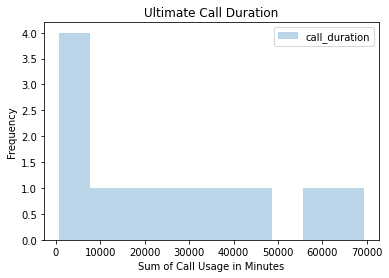

In [43]:
# Comparing the number of minutes users of each plan require each month.
surf_minute_his= agg_user.query('plan=="surf"').groupby('month').agg({'call_duration':'sum'}).plot(kind='hist',title='Surf Call Duration',xlabel='Month Usage in Minutes',alpha=0.3,legend=True)
plt.xlabel('Sum of Call Usage in Minutes')
ult_minute_his=agg_user.query('plan=="ultimate"').groupby('month').agg({'call_duration':'sum'}).plot(kind='hist',title='Ultimate Call Duration',xlabel="Month Usage in Minutes",alpha=0.3,legend=True)
plt.xlabel('Sum of Call Usage in Minutes')


In [44]:
# Calculating the mean and the variance of the monthly call duration
surf_avg_min=agg_user.query('plan=="surf"')['call_duration'].mean()
surf_var_min=agg_user.query('plan=="surf"')['call_duration'].var()
ult_avg_min=agg_user.query('plan=="ultimate"')['call_duration'].mean()
ult_var_min=agg_user.query('plan=="ultimate"')['call_duration'].var()

print('The average monthly call duration and variance for the Surf plan is',surf_avg_min,'and',surf_var_min)
print()
print('The average monthly call duration and variance for the Ultimate plan is',ult_avg_min,'and',ult_var_min)



The average monthly call duration and variance for the Surf plan is 436.51974110032364 and 52571.06324345624

The average monthly call duration and variance for the Ultimate plan is 434.67601683029454 and 56573.63224703341


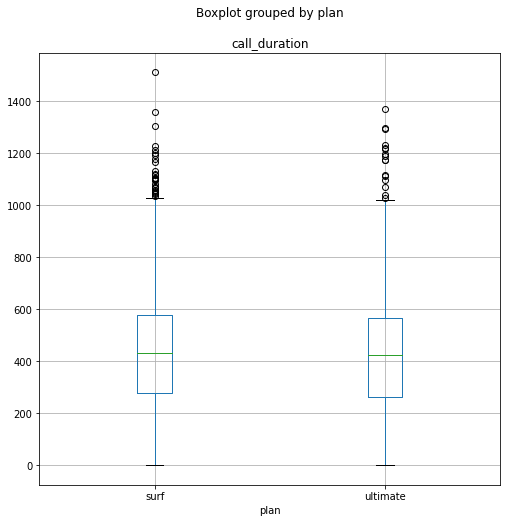

In [45]:
agg_user.boxplot(column='call_duration', by='plan', figsize=(8,8))
plt.show()


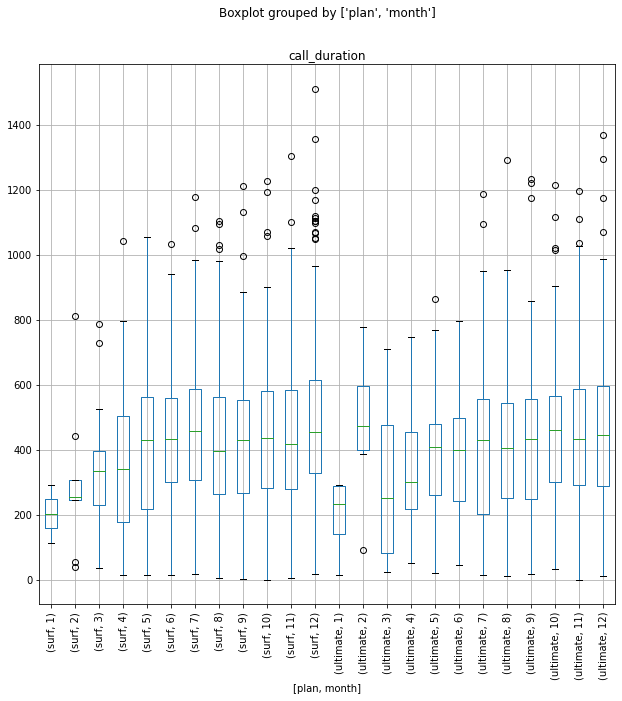

In [46]:
# Ploting a boxplot to visualize the distribution of the monthly call duration
agg_user.boxplot(column='call_duration', by=['plan','month'],figsize=(10,10), rot=90)


plt.show()

### Conclusion ###

Though there are instances of Surf plan users call duration sum being around 120,000 minutes, when comparing the average call duration between the plans, the means are not that different with Surf plan having a mean of around 436 minutes a month and Ultimate plan having a mean of around 434 minutes a month. The box plots show that there are more outliers with Surf plan but the variance is higher with the Ultimate plan.

### Messages

Text(0.5, 1.0, 'Number of Messages by Plan and Month')

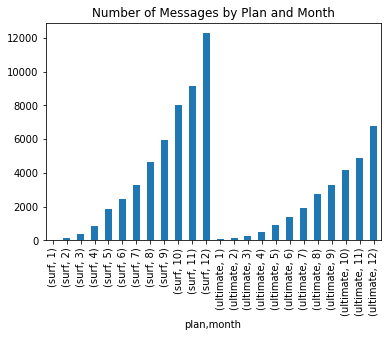

In [47]:
# Comparing the number of messages users of each plan tend to send each month
mess_plot=agg_user.groupby(['plan','month'])['message_count'].sum().plot(kind='bar')
plt.title('Number of Messages by Plan and Month')


In [48]:
surf_avg_mess=agg_user.query('plan=="surf"')['message_count'].mean()
surf_var_mess=agg_user.query('plan=="surf"')['message_count'].var()
ult_avg_mess=agg_user.query('plan=="ultimate"')['message_count'].mean()
ult_var_mess=agg_user.query('plan=="ultimate"')['message_count'].var()

print('The average number of messages sent a month and variance for the Surf plan is',surf_avg_mess,'and',surf_var_mess)
print()
print('The average number of messages sent a month and variance for the Ultimate plan is',ult_avg_mess,'and',ult_var_mess)


The average number of messages sent a month and variance for the Surf plan is 40.10965630114566 and 1091.3442310038054

The average number of messages sent a month and variance for the Ultimate plan is 46.29623287671233 and 1085.183107568317


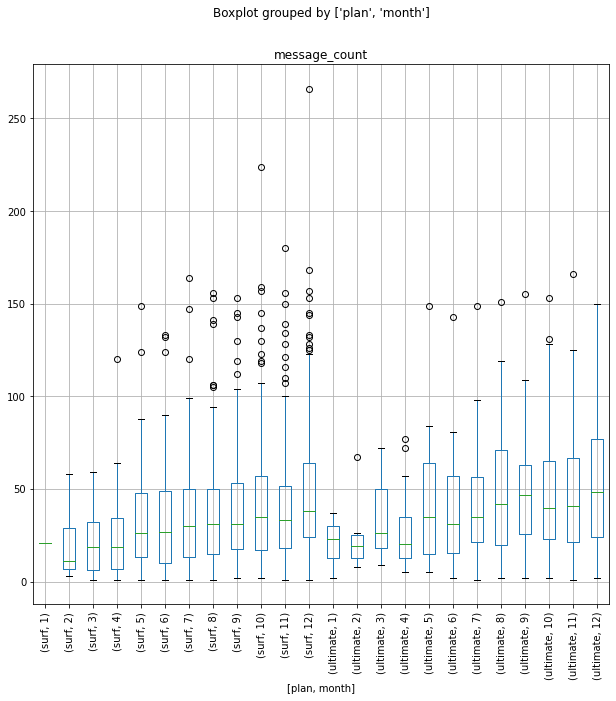

In [49]:
agg_user.boxplot(column='message_count', by=['plan','month'],figsize=(10,10), rot=90)

plt.show()

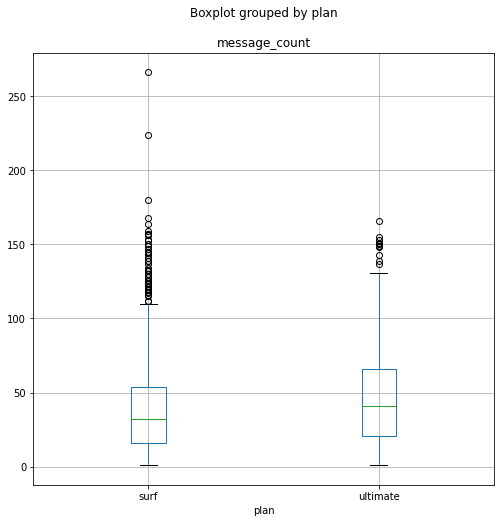

In [50]:
agg_user.boxplot(column='message_count', by='plan', figsize=(8,8))
plt.show()

### Conclusion ###
As stated above there are more customers enrolled in the Surf plan which can help explain the difference in the 'Number of Messages by Plan and Month' chart. Looking at the bar chart it is tempting to assume that Surf plan users send more messages a month on average than Ultimate plan users but that doesn't seem to be the case.
Surf plan users send an average of about 40 messages a month while Ultimate plan users send an average of about 46 messages a month.

### Internet

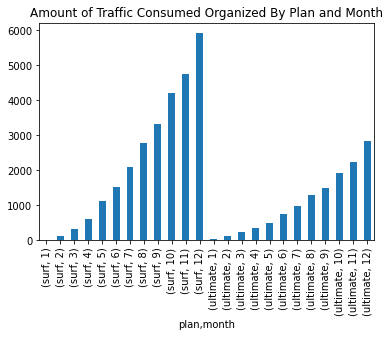

In [51]:
# Comparing the amount of internet traffic consumed by users per plan
int_plot=agg_user.groupby(['plan','month'])['gb_usage'].sum().plot(kind='bar')
plt.title('Amount of Traffic Consumed Organized By Plan and Month')
plt.show()

In [52]:
surf_avg_int=agg_user.query('plan=="surf"')['gb_usage'].mean()
surf_var_int=agg_user.query('plan=="surf"')['gb_usage'].var()
ult_avg_int=agg_user.query('plan=="ultimate"')['gb_usage'].mean()
ult_var_int=agg_user.query('plan=="ultimate"')['gb_usage'].var()

print('The average number of internet usage a month and its variance for the Surf plan is',surf_avg_int,'and',surf_var_int)
print()
print('The average number of internet usage a month and its variance for the Ultimate plan is',ult_avg_int,'and',ult_var_int)


The average number of internet usage a month and its variance for the Surf plan is 17.201540436456995 and 62.05826352148524

The average number of internet usage a month and its variance for the Ultimate plan is 17.744089012517385 and 61.511020025491916


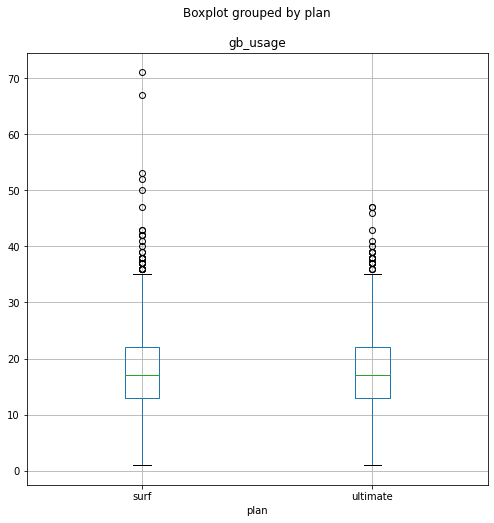

In [53]:
agg_user.boxplot(column='gb_usage', by='plan', figsize=(8,8))
plt.show()

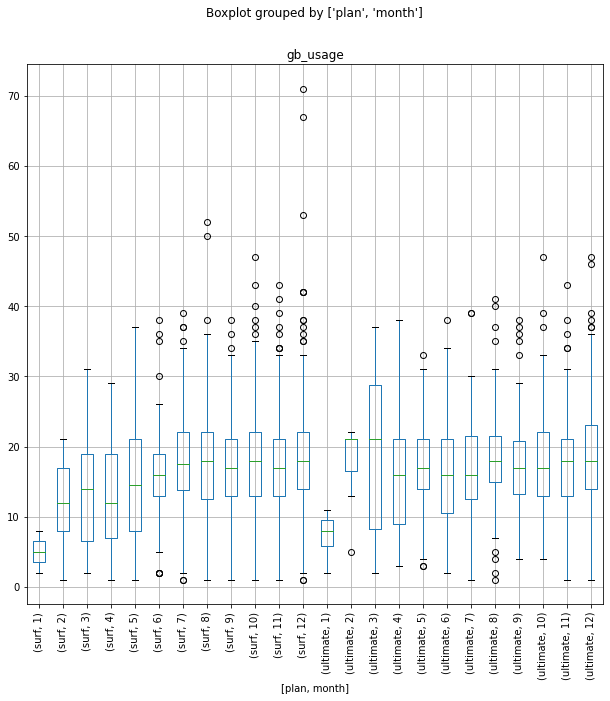

In [54]:
agg_user.boxplot(column='gb_usage', by=['plan','month'],figsize=(10,10), rot=90)
plt.show()

### Conclusions ###
Similarly to the message bar chart, it is tempting to assume that Surf plan users use more data on average every month, than Ultimate plan users. But unlike the message parameter, the average monthly data usage for both plans looks very similar, with both plans having users that spend around 17gb's a month with similiar variances as well.

## Revenue

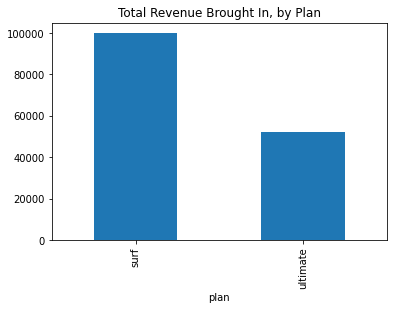

In [55]:
#total revenue brought in
agg_user.groupby('plan')['monthly_revenue'].sum().plot(kind='bar')
plt.title('Total Revenue Brought In, by Plan')
plt.show()

In [56]:
#avg monthly revenue brought in 
surf_avg_rev=agg_user.query('plan=="surf"')['monthly_revenue'].mean()
surf_var_rev=agg_user.query('plan=="surf"')['monthly_revenue'].var()
ult_avg_rev=agg_user.query('plan=="ultimate"')['monthly_revenue'].mean()
ult_var_rev=agg_user.query('plan=="ultimate"')['monthly_revenue'].var()

print('The average amount a customer is charged and its variance for the Surf plan is',surf_avg_rev,'and',surf_var_rev)
print()
print('The average amount a customer is charged and its variance for the Ultimate plan is',ult_avg_rev,'and',ult_var_rev)


The average amount a customer is charged and its variance for the Surf plan is 63.6116846789574 and 3295.5976941702293

The average amount a customer is charged and its variance for the Ultimate plan is 72.70277777777778 and 160.6069463761397


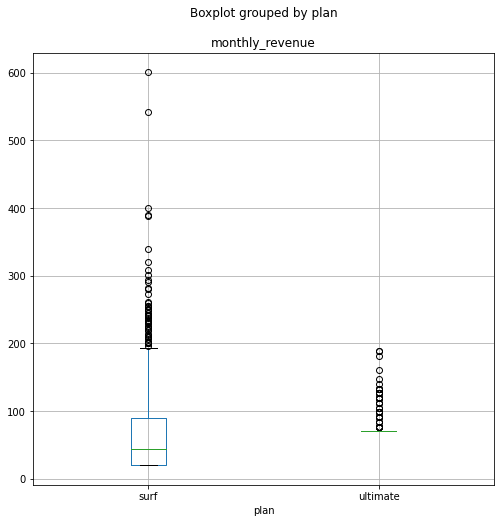

In [57]:
agg_user.boxplot(column='monthly_revenue', by='plan', figsize=(8,8))
plt.show()

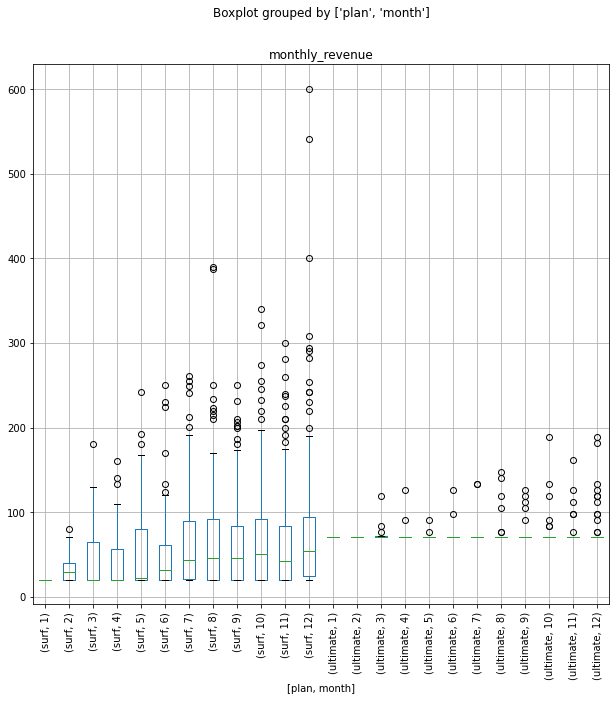

In [58]:
agg_user.boxplot(column='monthly_revenue', by=['plan','month'], figsize=(10,10), rot=90)
plt.show()

### Conclusion ###
One of the major goals of our analysis is to find out which plan brings in the most revenue. As there are more users using the Surf plan, it brings in a higher total revenue than the Ultimate plan at almost 100,000, while Ultimate brought in closer to 50,000 for 2018.
However, when you break it down into the average monthly revenue by plan, the Ultimate plan actually brings in more money with the Ultimate plan user being charged about 72 a month on average and the Surf plan users being charged an average of around 63 a month. 

## Test statistical hypotheses

Now I will test the hypothesis that the average revenue from users of the Ultimate and Surf calling plans differs.

In [59]:
# Test the hypotheses
"""H0: The average revenue of the Ultimate plan is equal to the average revenue of 
Surf plan
Ha: The average revenue of the Ultimate plan is not equal to the average revenue of the
Surf plan

"""
ult_rev= agg_user.query('plan=="ultimate"')['monthly_revenue']
surf_rev=agg_user.query('plan=="surf"')['monthly_revenue']
p_value_levene = stats.levene(ult_rev, surf_rev)
print(p_value_levene)
print(ult_rev.mean())
print(surf_rev.mean())
alpha = 0.05

results = stats.ttest_ind(ult_rev, surf_rev,equal_var=False)
print('p-value: ', results.pvalue)

if results.pvalue < alpha:
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")

LeveneResult(statistic=432.4350750021272, pvalue=4.005588978247873e-88)
72.70277777777778
63.6116846789574
p-value:  2.81373182813939e-09
We reject the null hypothesis


We will conduct a t-test to check the equality of these means. They are not paired so I used ttest_ind and since the variances are not equal, I made sure to include the parameter equal_var=False.
We can see that the means of the Ultimate and Surf plan are not equal with, Ultimate having a higher monthly revenue average. 
The hypothesis test and it's resulting p-value allows us to reject the null hypothesis as there is very little probability of getting a difference of the means this size or larger.

I wlll now test the hypothesis that the average revenue from users in the NY-NJ area is different from that of the users from the other regions.

In [60]:
# Test the hypotheses
"""H0: The average revenue of users in the NY-NJ area is equal to the average revenue of 
other plan users
Ha: The average revenue of users in the NY-NJ area is not equal to the average revenue of
other plan users """

ny_nj_users=agg_user.query('city.str.contains("NY")==1')['monthly_revenue']
others_users=agg_user.query('city.str.contains("NY")==0')['monthly_revenue']
p_value_levene = stats.levene(ult_rev, surf_rev)
print(p_value_levene)
print('Mean of NY/NJ Users',ny_nj_users.mean())
print('Mean of Other Users',others_users.mean())
alpha = 0.05

results = stats.ttest_ind(ny_nj_users, others_users,equal_var=False)
print('p-value: ', results.pvalue)

if results.pvalue < alpha:
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")

LeveneResult(statistic=432.4350750021272, pvalue=4.005588978247873e-88)
Mean of NY/NJ Users 63.73004926108375
Mean of Other Users 67.05499735029147
p-value:  0.19551827853120665
We can't reject the null hypothesis


Although the means of the NY/NJ users and other users are not equal, the p-value obtained tells us that there is a 12% chance of randomly getting a difference this size or larger. This is too high a probability to state that there is a significant difference between average monthly revenues.

## General conclusion



My goal was to ascertain which plan brought in the most revenue to aid in advertising. 
My first step was to get familiar with the data and to see if it needed any cleaning. Though there was very little cleaning, I did add a month column to each data set and change the data types when needed. 

After the pre-processing was then, I then aggregated the data based on the message, call, and internet parameters on a monthly and plan basis. Finally I found the monthly revenue of the users. 

In my initial analysis, I assumed that the Surf plan would bring in more revenue as it had more customers enrolled in the plan than Ultimate. If the advertising department is focusing on the total revenue, then I would tell them to put more money behind Surf plan advertising as that is the plan that brings in the most amount of money.
However, if the advertising team is focused on which plan brings in more money monthly, then they should focus their efforts on the Ultimate plan as that brings in more on average a month than the Surf plan does.

This is further bolstered by my first hypothesis test that resulted in my rejecting the null hypothesis that the average monthly revenue for the Surf and Ultimate plan were the same. 
The advertising department need not worry about customer region though (at least as far at NY/NJ is concerned). My second hypothesis test did not find enough evidence to reject the null hypothesis that NY/NJ users average monthly revenue is the same as users from other regions.

<div class="alert alert-success" role="alert">
<b>Reviewer's comment v1:</b>
    
- You conducted an outstanding research with correct interim findings, clean code and nice visualisation.
- I also like your overall conclusion. It is very structured and provides insights and recommendations to the business.